In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load data set from google drive

In [ ]:
import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/ml_lab/MLAssignment/final_data_64_64.csv')

extract labels and features as lists (first column is taken as labels and remaining all are cosidered as features)

In [ ]:
y = data.iloc[:, :1].values
X = data.iloc[:, 1:].values

converting labesl from list of list to list of elements

In [ ]:
print(X[0])

[ 25   0  18 ... 137  96  13]


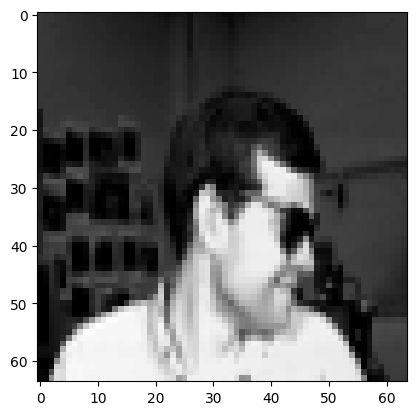

In [ ]:
import matplotlib.pyplot as plt
image1 = X[100].reshape(64,64)
plt.imshow(image1, cmap='gray')


normalizing data

In [ ]:
max_number = max(max(sublist) for sublist in X)
result_list = [[element / max_number for element in sublist] for sublist in X]

dividing data into training and testing

In [ ]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(result_list,y)

In [ ]:
import numpy as np
print(len(xtrain),len(ytrain))
print(len(xtrain[0]),ytrain[100])
import matplotlib.pyplot as plt
image1 = np.array(xtrain[100]).reshape(64,64)
plt.imshow(image1, cmap='gray')

Neural network

In [ ]:
import numpy as np

# Layer Class:
# Represents a single layer in a neural network.
class Layer:
  # Constructor:
  # Initializes the Layer object with the provided parameters.
  #
  # Parameters:
  # - nNeurons: The number of neurons in the layer.
  # - weights: The weights matrix representing connections between neurons in the current layer and the previous layer.
  # - bias: The bias vector for the neurons in the current layer.
  # - activation_function: The activation function applied to the output of the layer.
  # - activation_derivative: The derivative of the activation function, used for backpropagation.
  def __init__(self,nNeurons,weights,bias,activation_function,activation_derivative):
    self.nNeurons = nNeurons
    self.weights = weights
    self.bias = bias
    self.activation_function = activation_function
    self.activation_derivative = activation_derivative
    self.delta = None

  # Method: calculate_output
  # Computes the output of the layer given the input data.
  # If input_Layer is True, assumes the layer is the input layer and directly sets the output to the input data.
  # Otherwise, computes the weighted sum of the input data, adds the bias, applies the activation function, and stores the output.
  #
  # Parameters:
  # - data: The input data to the layer.
  # - input_Layer: Boolean flag indicating whether the layer is the input layer.
  #
  # Returns:
  # - output: The output of the layer.
  def calculate_output(self,data,input_Layer=False):
    if(input_Layer):
      self.output = data
    else:
      self.weighted_sum = np.dot(data,self.weights)+self.bias
      self.output = np.array(self.activation_function(self.weighted_sum))
    return self.output



# Network Class:
# Represents a neural network composed of multiple layers.
class Network:
  # Constructor:
  # Initializes the Network object with the number of layers.
  #
  # Parameters:
  # - nLayers: The number of layers in the network.
  def __init__(self,nLayers):
    self.nLayers=nLayers
    self.Layers=[]
    self.pred_output=[]
  # Activation Functions:
  # Define various activation functions used in the network.

  # Linear activation function.
  def linear(self,x):
    return x
  # ReLU (Rectified Linear Unit) activation function.
  def relu(self,x):
    return np.maximum(0,x)
  # Derivative of the ReLU activation function.
  def relu_derivative(self,x):
    return np.where(x < 0, 0, 1)
  # Softmax activation function.
  def softmax(self,x):
    exp_values=np.exp(x)
    expSum=np.sum(exp_values)
    return exp_values/expSum
  # Derivative of the softmax activation function.
  def softmax_derivative(self,x):
    return self.softmax(x) * (1 - self.softmax(x))


  # Method: Create_Network
  # Creates the network architecture by adding layers with specified parameters.
  #
  # Parameters:
  # - nInputs: The number of input neurons to the network.
  def Create_Network(self,nInputs):
    for i in range(self.nLayers-1):
      if i==0:
        weights=np.ones(nInputs)
        bias=np.ones((nInputs))
        self.Layers.append(Layer(nInputs,weights,bias,self.linear, self.linear))
      else:
        nNeurons=int(input(f"enter number of neurons of Layer {i+1} "))
        weights=0.1*np.random.randn(nInputs,nNeurons)
        bias=0.1*np.random.randn((nNeurons))
        self.Layers.append(Layer(nNeurons,weights,bias,self.relu, self.relu_derivative))
        nInputs=nNeurons
    nNeurons=int(input(f"enter number of neurons in output layer "))
    weights=0.1*np.random.randn(nInputs,nNeurons)
    bias=np.zeros((nNeurons))
    self.Layers.append(Layer(nNeurons,weights,bias,self.softmax, self.softmax_derivative))

  # Method: forwardPass
  # Performs a forward pass through the network.
  #
  # Parameters:
  # - Input_data: The input data to be passed through the network.
  #
  # Returns:
  # - Output_data: The output data produced by the network.
  def forwardPass(self,Input_data):
    for i in range(self.nLayers):
      if(i==0):
        Input_data=self.Layers[i].calculate_output(Input_data,True)
      else:
        Input_data=self.Layers[i].calculate_output(Input_data)
    return Input_data

  # Method: calculate_deltas
  # Calculates delta values for each layer in the network during backpropagation.
  #
  # Parameters:
  # - targets: The target values for the current training batch.
  def calculate_deltas(self, targets):
    for i in range(self.nLayers - 1, 0, -1):
      if i == len(self.Layers)-1:
        self.Layers[i].delta = (self.Layers[i].output - targets)
      else:
        self.Layers[i].delta = np.dot(self.Layers[i+1].delta,self.Layers[i+1].weights.T) * self.Layers[i].activation_derivative(self.Layers[i].weighted_sum)

  # Method: Update_Weights
  # Updates the weights and biases of each layer in the network using gradient descent.
  #
  # Parameters:
  # - lr: The learning rate for gradient descent.
  def Update_Weights(self,lr):
    for i in range(self.nLayers - 1, 0, -1):
      self.Layers[i].bias -= np.dot(lr, self.Layers[i].delta)
      self.Layers[i].weights -= self.Layers[i].delta[np.newaxis,:] * (np.dot(lr,self.Layers[i-1].output)[:, np.newaxis]  * self.Layers[i].weights)

  # Method: calculate_error
  # Calculates the error between predicted outputs and target values.
  #
  # Parameters:
  # - targets: The target values for the current training batch.
  # - outputs: The predicted outputs produced by the network.
  #
  # Returns:
  # - loss: The error between predicted outputs and target values.
  def calculate_error(self, targets, outputs):
      epsilon = 1e-15
      outputs = np.clip(outputs, epsilon, 1 - epsilon)
      loss = - np.sum(targets * np.log(outputs))
      return loss

  # Method: backwardPass
  # Performs a backward pass through the network (backpropagation) to update weights and biases.
  #
  # Parameters:
  # - targets: The target values for the current training batch.
  # - lr: The learning rate for gradient descent.
  def backwardPass(self,targets, lr):
    self.calculate_deltas(targets)
    self.Update_Weights(lr)

  # Method: One_hot
  # Encodes the target labels using one-hot encoding.
  #
  # Parameters:
  # - x: The target label to be encoded.
  #
  # Returns:
  # - ans: The one-hot encoded target label.
  def One_hot(self,x):
    ans = []
    for i in range(4):
      if(i==x):
        ans.append(1)
      else:
        ans.append(0)
    return np.array(ans)


  # Method: fit
  # Trains the network on the provided input data and target labels for the specified number of epochs.
  #
  # Parameters:
  # - input_datas: The input data for training.
  # - target_labels: The target labels for training.
  # - epochs: The number of training epochs.
  # - learning_rate: The learning rate for gradient descent.
  def fit(self, input_datas, target_labels, epochs, learning_rate):
      for epoch in range(epochs):
        total_error = 0
        for input_data,target in zip(input_datas, target_labels):
          outputs = self.forwardPass(input_data)
          targets = self.One_hot(target)
          error = self.calculate_error(targets, outputs)
          total_error+=error
          self.backwardPass(targets, learning_rate)
        print(f"Epoch {epoch + 1} / {epochs}, Error: {total_error/len(input_datas)}")

  # Calculate the accuracy of the neural network on the test dataset.
  # Parameters:
  # - xtest (array-like): Input test data.
  # - ytest (array-like): True labels for the test data.
  # Returns:
  # - accuracy (float): Accuracy of the neural network on the test dataset.
  def calculate_accuracy(self, xtest, ytest):
    correct_predictions = 0
    total_samples = len(ytest)
    for input_data, output_data in zip(xtest, ytest):
      output = self.forwardPass(input_data)
      predicted_class = np.argmax(output)
      if predicted_class == output_data and output[predicted_class] >= 0.9:
        correct_predictions += 1
    accuracy = correct_predictions / total_samples
    return accuracy

nLayers=int(input("enter number of layers"))

obj=Network(nLayers)  #object for Network class
obj.Create_Network(4096)  #creates a network by creating layers and appending to Layers list in Network class (this takes input length as argument)


enter number of layers6
enter number of neurons of Layer 2 1024
enter number of neurons of Layer 3 512
enter number of neurons of Layer 4 256
enter number of neurons of Layer 5 128
enter number of neurons in output layer 4


Training of NN

In [ ]:
obj.fit(xtrain, ytrain, 20, 0.005)

In [ ]:
acc = 0
for input_data, output_data in zip(result_list, y):
  output = obj.forwardPass(input_data)
  if output[output_data] >= 0.9:
    acc+=1
print(acc/len(y))

0.9903846153846154


In [ ]:
import pickle

# Define the path to the .pkl file
pkl_file_path = "/content/drive/MyDrive/ml_lab/MLAssignment/saved_network_64_64.pkl"

# Open the .pkl file for reading in binary mode
with open(pkl_file_path, "rb") as file:
    # Load the contents of the .pkl file
    data = pickle.load(file)

# Now 'data' contains the contents of the .pkl file
# You can process or store the data as needed
print(data)

{'layer_0_weights': array([1., 1., 1., ..., 1., 1., 1.]), 'layer_0_bias': array([1., 1., 1., ..., 1., 1., 1.]), 'layer_1_weights': array([[ 0.04859782,  0.1989095 ,  0.07222689, ..., -0.0497807 ,
         0.11589078,  0.03887353],
       [-0.12825834,  0.15324809, -0.01416208, ..., -0.09900302,
        -0.11432299, -0.04143484],
       [ 0.07527275, -0.28677987, -0.02173431, ...,  0.03346958,
        -0.00781088, -0.0753021 ],
       ...,
       [-0.07092112,  0.00988692, -0.14234828, ...,  0.13650788,
         0.22745089, -0.1953906 ],
       [-0.01793325, -0.06295498,  0.010147  , ..., -0.13026341,
         0.04192441,  0.00874272],
       [ 0.01344231, -0.08154319,  0.00374596, ...,  0.10118938,
        -0.0278149 ,  0.27621942]]), 'layer_1_bias': array([-0.05309346,  0.51050421, -0.08467082, ...,  0.13939321,
       -0.25132077,  0.50297776]), 'layer_2_weights': array([[ 0.27899292,  0.04480144,  0.20636746, ...,  0.01429166,
        -0.01770514,  0.15431969],
       [ 0.0455162 , 

In [ ]:
obj1 = Network(6)
obj1.Create_Network(4096)

enter number of neurons of Layer 2 1024
enter number of neurons of Layer 3 512
enter number of neurons of Layer 4 256
enter number of neurons of Layer 5 128
enter number of neurons in output layer 4


Trining Model

In [ ]:
obj.fit(xtrain, ytrain, 20, 0.03)

Finding accuracy of NN

In [ ]:
acc = 0
for input_data, output_data in zip(result_list, y):
  output = obj1.forwardPass(input_data)
  if output[output_data] >= 0.9:
    acc+=1
print(acc/len(y))

0.9855769230769231


Observing Outputs of Each Sample

In [ ]:
# test_data = [image.flatten() for image in xtest]
#for train data
for input_data, output_data in zip(result_list, y):
  print(output_data,"  ",obj.forwardPass(input_data))
print()

[0]    [9.97069892e-01 2.38550347e-03 6.15665254e-05 4.83038145e-04]
[0]    [9.97942000e-01 1.85192243e-03 4.54689648e-05 1.60608411e-04]
[0]    [9.99020584e-01 2.10753879e-04 2.59649891e-04 5.09012383e-04]
[0]    [9.71857813e-01 2.21727636e-02 6.00707402e-05 5.90935293e-03]
[0]    [9.47748610e-01 2.02686055e-02 5.72644815e-05 3.19255204e-02]
[0]    [9.88476534e-01 4.02012805e-03 1.07526702e-04 7.39581077e-03]
[0]    [2.87211242e-02 7.47924579e-02 2.66962676e-04 8.96219455e-01]
[0]    [4.49629740e-02 7.62596733e-02 6.14315310e-04 8.78163037e-01]
[0]    [1.14287319e-01 2.04964949e-02 2.95085201e-04 8.64921101e-01]
[0]    [0.89347097 0.01384216 0.08575759 0.00692928]
[0]    [0.90782181 0.01886458 0.06962324 0.00369037]
[0]    [0.98322651 0.00595556 0.0055321  0.00528583]
[0]    [0.79563405 0.1728332  0.00574049 0.02579226]
[0]    [0.73305461 0.14068238 0.03701258 0.08925044]
[0]    [0.36306253 0.05910636 0.00199455 0.57583656]
[0]    [0.39943511 0.1095346  0.00722358 0.48380671]
[0]    [

Testing with single image

In [ ]:
import cv2
import numpy as np
# Load the image from Google Drive (grayscale)
image_path = '/content/drive/MyDrive/ml_lab/MLAssignment/faces/left/an2i_left_angry_open.jpg'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Resize the image to 30x32 pixels
resized_image = cv2.resize(image, (64, 64))

# Flatten the resized image
flattened_image = resized_image.flatten()

# Normalize the pixel values
normalized_image = flattened_image / 255.0

# Store the normalized pixel values in a list
input_image = normalized_image.tolist()

# Display the shape of the normalized pixel values
print("Shape of normalized pixel values:", np.array(input_image).shape)

print(obj.forwardPass(input_image))

Shape of normalized pixel values: (4096,)
[9.99999997e-01 8.43273780e-10 3.24828185e-23 2.13914859e-09]


Saving Model after trining

In [ ]:
state_dict = {}
for i, layer in enumerate(obj.Layers):
    state_dict[f"layer_{i}_weights"] = layer.weights
    state_dict[f"layer_{i}_bias"] = layer.bias

# Store the state dictionary within the object itself
state = state_dict

In [ ]:
print(state['layer_3_weights'].shape)

(512, 256)


Loading Saved Model

In [ ]:
import pickle

# Save the serialized state to a file in Google Drive
filename = '/content/drive/MyDrive/ml_lab/MLAssignment/saved_network_64_64_1.pkl'
with open(filename, 'wb') as file:
    pickle.dump(state, file)


In [ ]:
filename = '/content/drive/MyDrive/ml_lab/MLAssignment/saved_network_30_32.pkl'
with open(filename, 'rb') as file:
    loaded_state = pickle.load(file)

# Update the state of the network object 'obj' with the loaded state
state2 = loaded_state

In [ ]:
print(state2['layer_1_bias'])

Loading Trained Model Weights And Biases

In [ ]:
obj1.Layers[0].weights = data['layer_0_weights']
obj1.Layers[0].bias = data['layer_0_bias']
obj1.Layers[1].weights = data['layer_1_weights']
obj1.Layers[1].bias = data['layer_1_bias']
obj1.Layers[2].weights = data['layer_2_weights']
obj1.Layers[2].bias = data['layer_2_bias']
obj1.Layers[3].weights =data['layer_3_weights']
obj1.Layers[3].bias =data['layer_3_bias']
obj1.Layers[4].weights =data['layer_4_weights']
obj1.Layers[4].bias =data['layer_4_bias']


obj1.Layers[5].weights =data['layer_5_weights']
obj1.Layers[5].bias =data['layer_5_bias']